# Practice 1
**Author: Jorge Vázquez Pérez**

## Table of Contents

1. [Preprocessing](#apartado1)
2. [Develop a classical neural network to predict class of each image](#apartado2)
3. [Regularization](#apartado3)
4. [Results](#apartado4)
5. [Conclusions](#apartado5)

We start by loading the datase of fashion MNIST.

In [1]:
%%capture
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data();

2023-11-28 20:20:03.853425: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-28 20:20:03.854494: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 20:20:03.875805: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 20:20:03.876288: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 20:20:04.263859: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

It can efectively be seen that we are working with a dataset of 64x64 images in a gray scale.

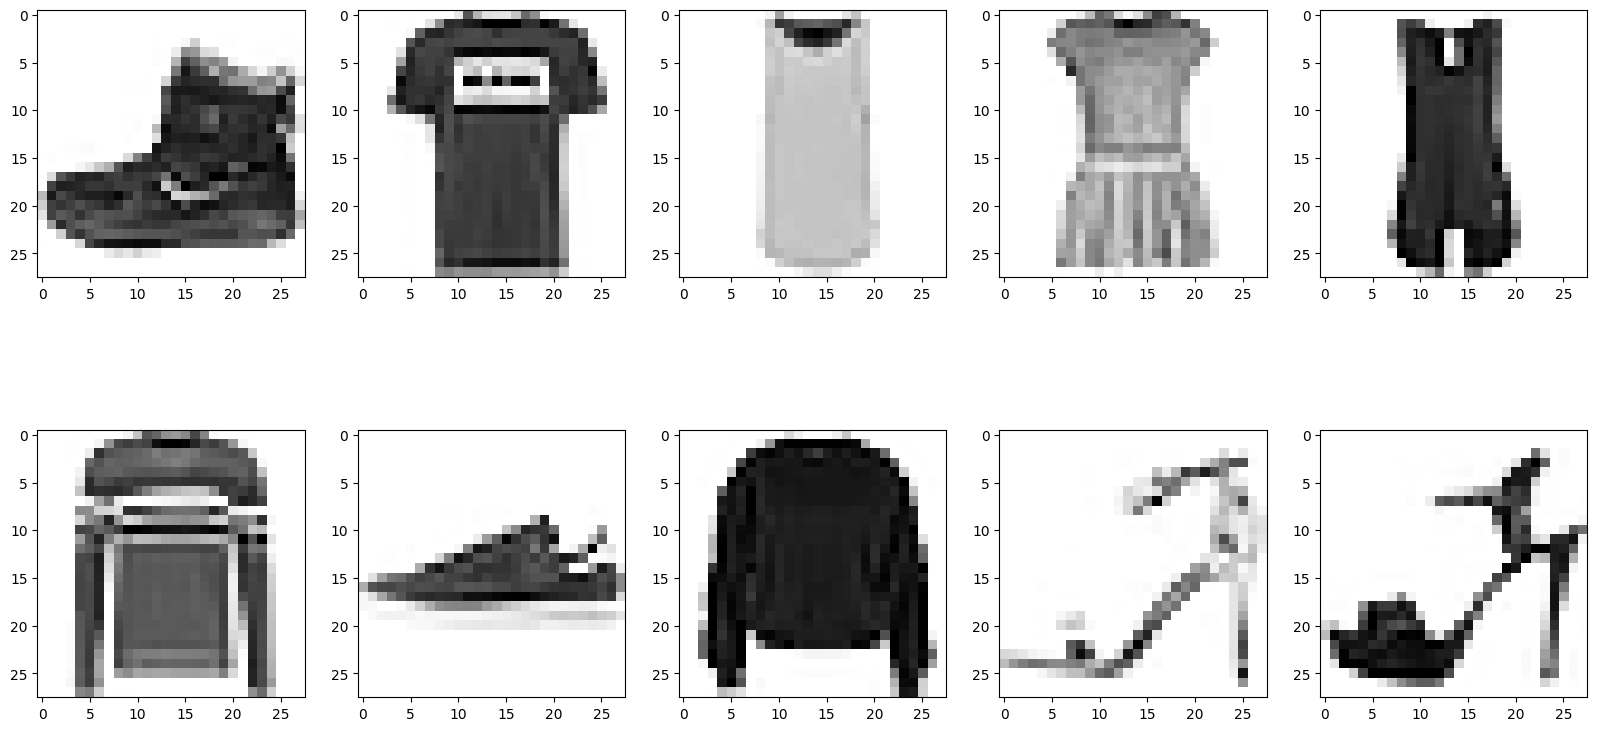

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'Greys'
plt.figure(figsize=(20,10))
ncols = 5
nrows = 2
for i, image in enumerate(x_train[:nrows*ncols]):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(image)

And the tags for the shown images correctly correspong to the tags we expected.

In [3]:
print("The tags for the previous images are:")
for i in range(nrows):
    print(y_train[i*ncols:(i+1)*ncols])

The tags for the previous images are:
[9 0 0 3 0]
[2 7 2 5 5]


## Preprocessing <a class="anchor" id="apartado1"></a>

Now that the dataset has been successfully loaded into the notebook, we can proceed with the data preprocessing. As anticipated, the shape of the images is as follows.

In [4]:
print("Shape of image train set is: ", x_train.shape)
print("Shape of image test set is: ", x_test.shape)

Shape of image train set is:  (60000, 28, 28)
Shape of image test set is:  (10000, 28, 28)


As a next step, we will flatten the image to create a linear array shape, which will allow us to input the values into the neural network. Additionally, we will transform the value of each pixel from an integer ranging from 0 to 255 to a 32-bit floating-point number ranging from 0 to 1. This transformation serves various purposes, including enhancing numerical stability, expediting convergence and improving weight initialization, among others.

In [5]:
x_train = x_train.reshape((60000, 28 * 28))
x_train = x_train.astype('float32') / 255

x_test = x_test.reshape((10000, 28 * 28))
x_test = x_test.astype('float32') / 255

print("Shape of image train set is: ", x_train.shape)
print("Shape of image test set is: ", x_test.shape)

Shape of image train set is:  (60000, 784)
Shape of image test set is:  (10000, 784)


Concerning the tags, we convert them into a binary vector. This conversion is performed to ensure uniqueness, avoid ordinal assumptions and simplify model integration and interpretation. The usefulness of this approach becomes more evident when dealing with non-numerical categories.

In [6]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Last but not least, we create a validation subset from the training set. In this case, we opt not to employ the k-fold cross-validation method. The reason being that Fashion MNIST is already sufficiently large and diverse, and dividing it into k subsets for testing would consume significant time and computational resources with minimal benefit. Instead, we adopt a simpler approach by splitting the data into two sets: 80% for training and 20% for validation. For this the `sklearn` function `train_test_split` will be used.

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=32)

## Develop a classical neural network to predict class of each image <a class="anchor" id="apartado2"></a>

First we will define a function to plot different models and compare.

In [8]:
def plot_models(histories):
    fig, axs = plt.subplots(2, len(histories), figsize=(18, 8))
    for i, history in enumerate(histories):
        history_dict = history.history
        epochs = range(1, len(history_dict['loss']) + 1)
        axs[0][i].plot(epochs, history_dict['loss'], 'b-o', label='Training loss')
        axs[0][i].plot(epochs, history_dict['val_loss'], 'r-o', label='Validation loss')
        axs[0][i].set_title('Model {}'.format(i+1))
        axs[0][i].set_xlabel('Epochs')
        axs[0][i].set_ylabel('Loss')
        axs[0][i].legend()

    for i, history in enumerate(histories):
        history_dict = history.history
        epochs = range(1, len(history_dict['loss']) + 1)
        axs[1][i].plot(epochs, history_dict['accuracy'], 'b-o', label='Training accuracy')
        axs[1][i].plot(epochs, history_dict['val_accuracy'], 'r-o', label='Validation accuracy')
        axs[1][i].set_title('Model {}'.format(i+1))
        axs[1][i].set_xlabel('Epochs')
        axs[1][i].set_ylabel('Accuracy')
        axs[1][i].legend()
    
    # Display the plot
    plt.tight_layout()
    plt.show()

### Structural hyperparameters

Now, let's delve into the structure of the neural network (NN). In this section, we will determine three key aspects: the number of hidden layers, the number of neurons per layer and the activation function of the neurons. This is indeed a challenging task, given the numerous possible combinations and the absence of a one-size-fits-all solution. We will base our decisions on the following guiding principles:

- Minimizing resource usage.
- Mitigating overfitting.
- Minimizing validation loss.

These three criteria will guide our decision-making process for defining the NN structure. Given the vast search space, when attempting to determine the value of a hyperparameter, we will fix the values of the other two to observe how that specific hyperparameter alone affects the results. Let's begin with the number of hidden layers.

2023-11-28 20:20:05.726303: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 20:20:05.745925: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Training different models to compare... Done.


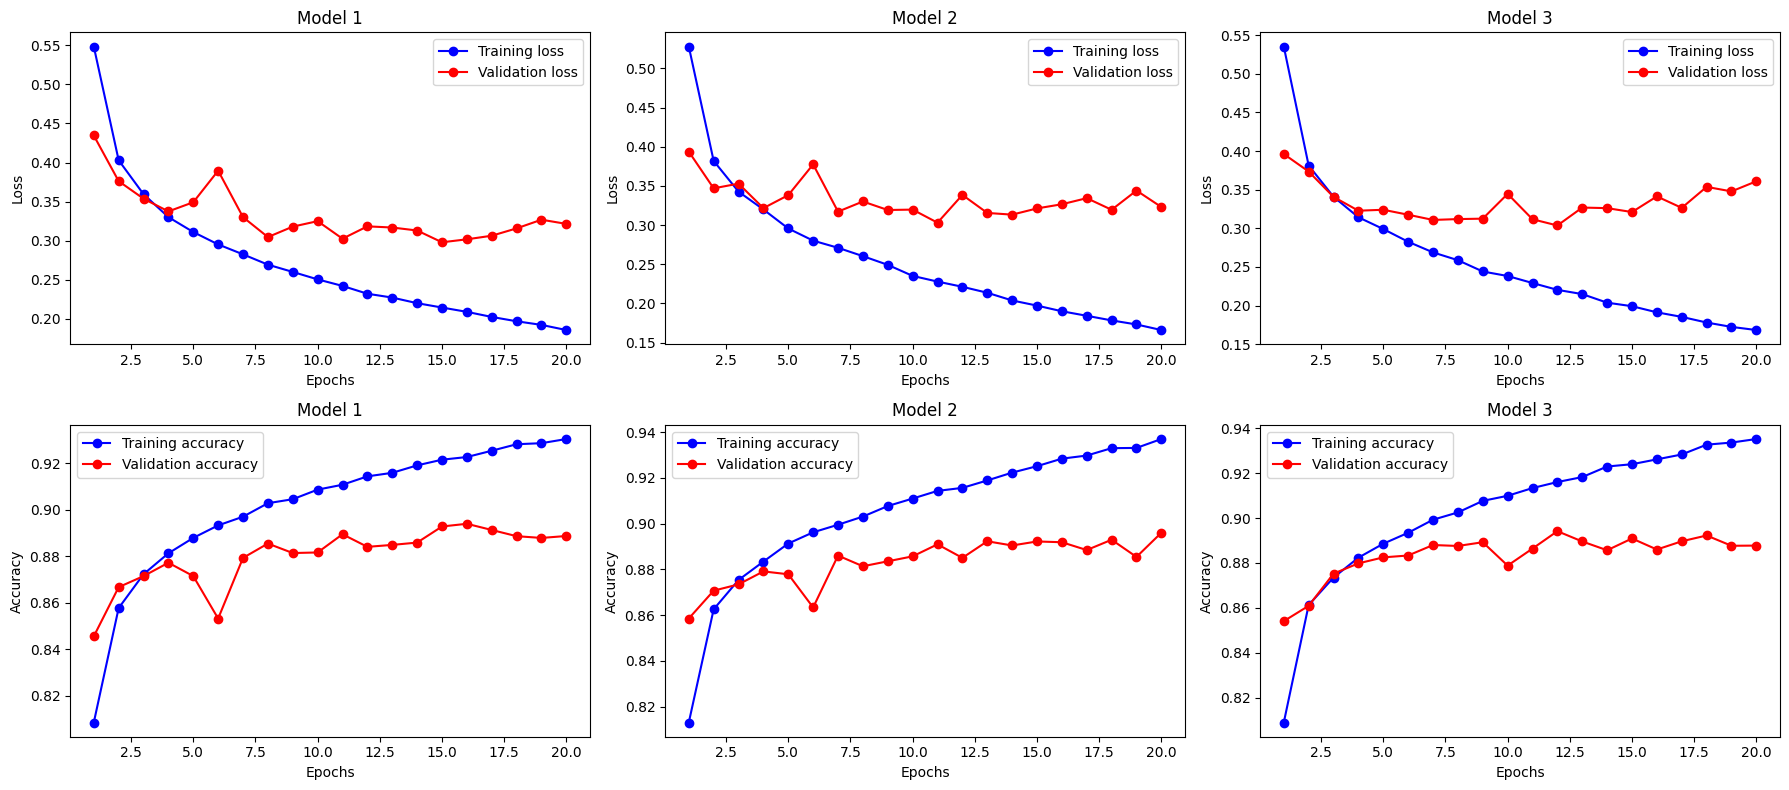

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Define the model
model1 = Sequential([
    Flatten(input_shape=(784,)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])

# Define the model
model2 = Sequential([
    Flatten(input_shape=(784,)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])

# Define the model
model3 = Sequential([
    Flatten(input_shape=(784,)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])

for model in [model1, model2, model3]:
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

print("Training different models to compare...", end=" ")
history1 = model1.fit(x_train, y_train, epochs = 20, batch_size = 64, validation_data = (x_val, y_val), verbose=0)
history2 = model2.fit(x_train, y_train, epochs = 20, batch_size = 64, validation_data = (x_val, y_val), verbose=0)
history3 = model3.fit(x_train, y_train, epochs = 20, batch_size = 64, validation_data = (x_val, y_val), verbose=0)
print("Done.")

plot_models([history1, history2, history3])

In this case, we observe that the validation loss remains consistently around 0.3 for each configuration, suggesting that opting for a single hidden layer would be a prudent choice to minimize resource usage. Additionally, the fact that the training loss decreases in the last two models indicates an increase in overfitting, as the validation loss fails to improve. Consequently, moving forward, our model will comprise only one hidden layer.

Now, let's proceed to determining the number of neurons per layer.

Training different models to compare... Done.


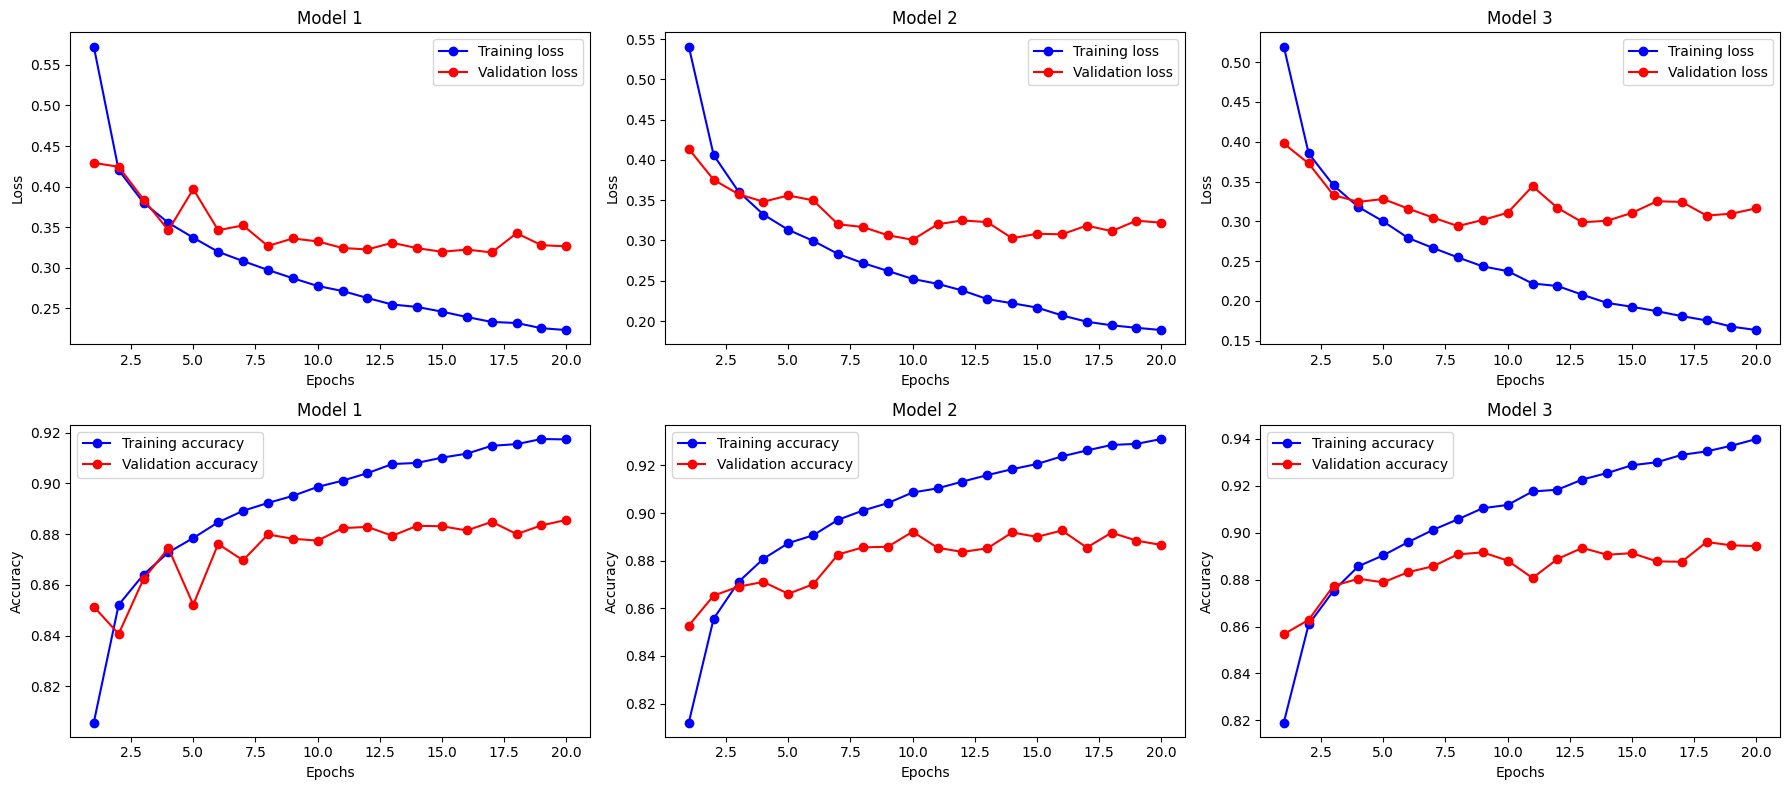

In [10]:
model1_ = Sequential([
    Flatten(input_shape=(784,)),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])

model2_ = Sequential([
    Flatten(input_shape=(784,)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])

model3_ = Sequential([
    Flatten(input_shape=(784,)),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])

for model in [model1_, model2_, model3_]:
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

print("Training different models to compare...", end=" ")
history1_ = model1_.fit(x_train, y_train, epochs = 20, batch_size = 64, validation_data = (x_val, y_val), verbose=0)
history2_ = model2_.fit(x_train, y_train, epochs = 20, batch_size = 64, validation_data = (x_val, y_val), verbose=0)
history3_ = model3_.fit(x_train, y_train, epochs = 20, batch_size = 64, validation_data = (x_val, y_val), verbose=0)
print("Done.")

plot_models([history1_, history2_, history3_])

Once more, the third model exhibits signs of overfitting due to the limited improvement achieved in the validation set compared to the training set. When considering the first and second models, a challenging decision arises. While the overfitting in the second model doesn't appear as severe as in the third, it involves doubling the number of neurons, leading to a significant increase in resource usage. Although the second model shows improvement in the validation loss, the question remains: is this improvement substantial enough to justify doubling the resources?

To make a final decision, we will evaluate the models against the test set.

In [11]:
results = model1_.evaluate(x_test, y_test)
results = model2_.evaluate(x_test, y_test)

313/313 [==============================] - 0s 743us/step - loss: 0.3637 - accuracy: 0.8756


Upon evaluating the models against the test set, we observe that the loss and accuracy are nearly identical in both cases. Consequently, we will opt for the configuration with 64 neurons in the hidden layer, given the lack of significant improvement and the additional resource cost associated with the second model.

Now, let's proceed to the final structural hyperparameter: comparing four activation functions.

In [12]:
activation_functions = ['relu', 'sigmoid', 'tanh', 'softmax']

results = {}
for activation in activation_functions:
    model = Sequential([
        Flatten(input_shape=(784,)),
        Dense(64, activation=activation),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    print(f"\nTraining model with {activation} activation...", end=" ")
    history = model.fit(x_train, y_train, batch_size = 64, validation_data=(x_val, y_val), epochs=20, verbose=0)
    print(f"Done.")

    score = model.evaluate(x_test, y_test, verbose=0)
    results[activation] = score[1]  # store the accuracy

print(f"------ Activation results --------\n\n")
for activation, accuracy in results.items():
    print(f"Accuracy with {activation} activation: {accuracy:.4f}")


Training model with relu activation... Done.

Training model with sigmoid activation... Done.

Training model with tanh activation... Done.

Training model with softmax activation... Done.
------ Activation results --------


Accuracy with relu activation: 0.8756
Accuracy with sigmoid activation: 0.8812
Accuracy with tanh activation: 0.8786
Accuracy with softmax activation: 0.8188


Looking at the accuracies, the decision falls between ReLU, sigmoid and tanh. We will choose ReLU for two reasons: its simplicity and its addressing of the vanishing gradient problem.

### Learning parameters

When addressing learning parameters, we notice that the number of them increases compared to structural parameters. Specifically, we will focus on the following learning parameters: optimizer, learning rate, epochs, batch size and metrics.

In this case, instead of manually evaluating each hyperparameter while fixing the others to observe the impact of different values, we will adopt a more efficient technique using the `keras_tuner` package. This package provides methods like Bayesian search or grid search, which aim to explore a search space defined by us to find the best set of hyperparameters. For our scenario, we will provide a set of three values around the ones used in the previous section, as we have already achieved acceptable results with those values.

The only hyperparameter among those mentioned earlier that we won't search using this method is the batch size. Increasing the batch size primarily serves to reduce time resource consumption. In our case, we will maintain it at 32, as it is sufficiently small and does not create a significant bottleneck in terms of time consumption. We also do this to not make the search space even bigger for the grid search method adding another hyperparameter.

In [14]:
import tensorflow as tf
from keras_tuner import HyperModel
from keras_tuner.tuners import GridSearch

class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential([
            Flatten(input_shape=(784,)),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax')
        ])
    
        # Hyperparameters to tune
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
        hp_optimizer = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
        hp_metric = hp.Choice('metrics', values=['accuracy', 'precision'])
    
        # Choose the optimizer
        if hp_optimizer == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
        elif hp_optimizer == 'sgd':
            optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)
        else:
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
    
        model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=hp_metric)
    
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            epochs=hp.Choice("epochs", [10, 15]),
            **kwargs,
        )    

# Create a GridSearch tuner
tuner = GridSearch(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=24,
    directory='tuner_dir',
    project_name='grid_search'
)

# Perform the hyperparameter search
tuner.search(x_train, y_train, batch_size=32, validation_data=(x_val, y_val))

Trial 24 Complete [00h 00m 00s]

Best val_accuracy So Far: 0.8885833621025085
Total elapsed time: 00h 04m 33s


Once we have searched the hyperparameters, we can output their values and train a model with them in order to see the results.

In [15]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

optimizer = best_hps.get('optimizer')
learning_rate = best_hps.get('learning_rate')
metric = best_hps.get('metrics')
epochs = best_hps.get('epochs')
batch_size = 32

print(f""" The hyperparameter search is complete.
- Best optimizer: {optimizer}.
- Best learning rate: {learning_rate}.
- Best metric: {metric}.
- Best epochs: {epochs}.
""")

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)

print("\nTraining the final model...", end=" ")
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose = 0)
print("Done.")

 The hyperparameter search is complete.
- Best optimizer: adam.
- Best learning rate: 0.001.
- Best metric: accuracy.
- Best epochs: 15.


Training the final model... Done.


And now, all the values of the hyperparameters have been obtained. Let's look at the validation loss and the validation accuracy of our model.

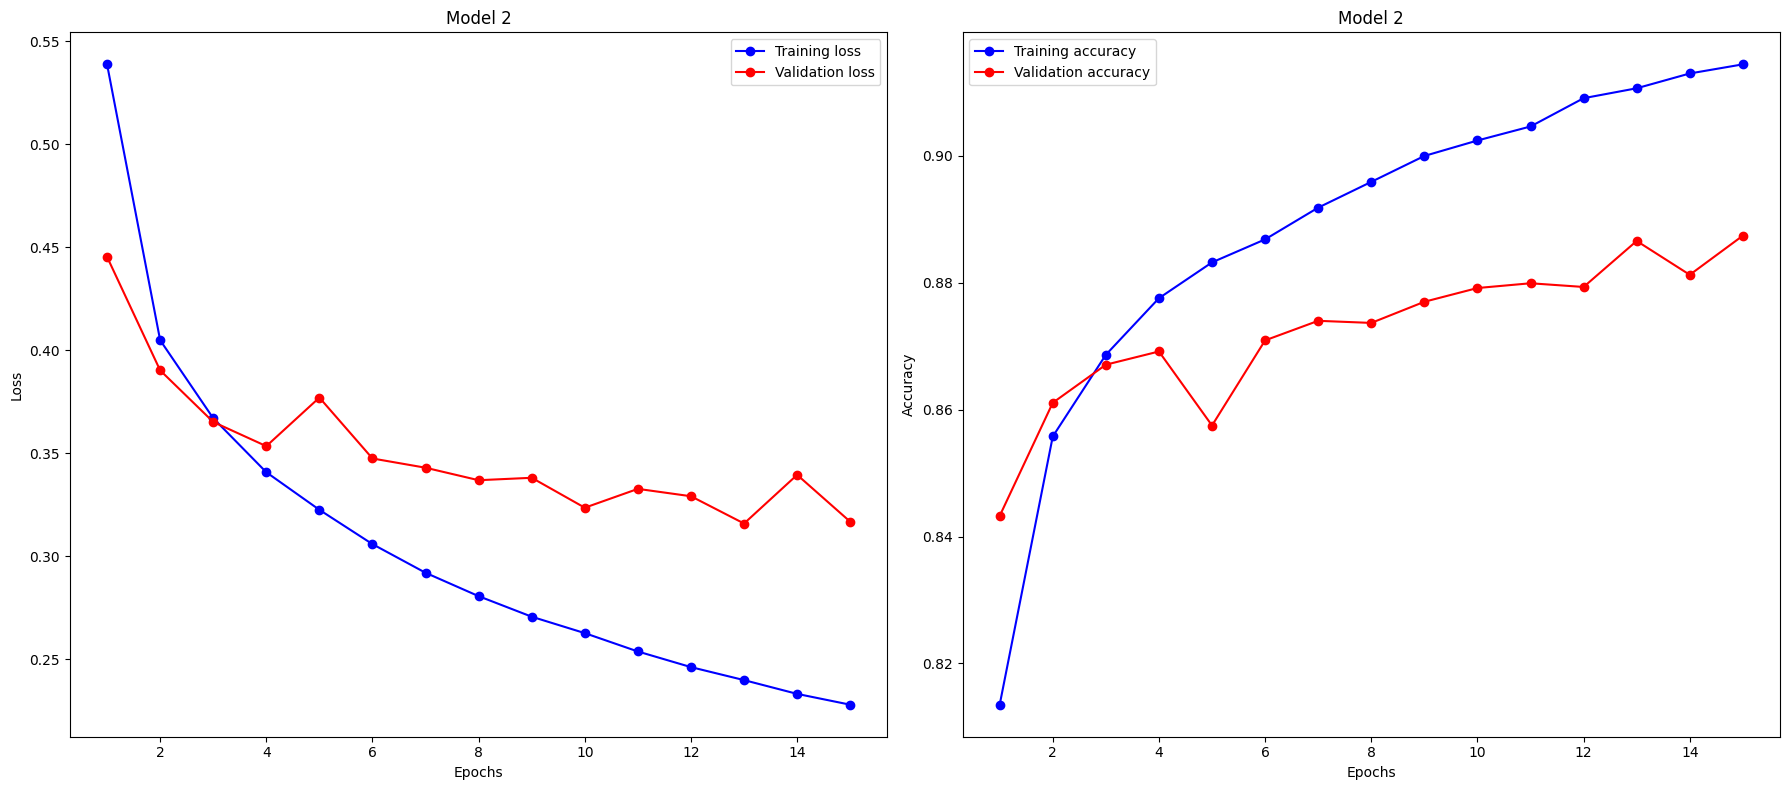

In [16]:
def plot_model(history_):
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))
    history_dict = history.history
    epochs = range(1, len(history_dict['loss']) + 1)
    
    axs[0].plot(epochs, history_dict['loss'], 'b-o', label='Training loss')
    axs[0].plot(epochs, history_dict['val_loss'], 'r-o', label='Validation loss')
    axs[0].set_title('Model {}'.format(i+1))
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(epochs, history_dict['accuracy'], 'b-o', label='Training accuracy')
    axs[1].plot(epochs, history_dict['val_accuracy'], 'r-o', label='Validation accuracy')
    axs[1].set_title('Model {}'.format(i+1))
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    
    # Display the plot
    plt.tight_layout()
    plt.show()

plot_model(history)

And, finally, we can test the model with the test data in order to obtain the actual accuracy of our model.

In [17]:
results = model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 601us/step - loss: 0.3417 - accuracy: 0.8795


Although the results have nice accuracy, if we focus on the plot displayed we still see some overfitting. In the next section, using the hyperparameters obtained in this section we are going to try to reduce that overfitting in order to obtain a better accuracy on the final model.

## Regularization <a class="anchor" id="apartado3"></a>

In this section we are going to develop some regularization technieques in order to improve the overfitting of our model, which is not critical, but it can be still enhanced. In order to make this section lighter than the previous ones, we are going to make our analysis using the evaluation of the model agaist the test set, instead of looking at the graphic and comparing the validation data with the training data. Moreover, if some of these techniques make the results worse we are not going to explain why: the causes can be multiple and difficult to analyze. We will explain the theory behind these methods and apply them to our NN indiviually to see if we should incorporate them.

First, we will add a dropout layer in between the hidden and the final layer. In order to get the best dropout rate possible we will apply a bayesian search, similar to the grid search, but using a probabilistic model.

In [18]:
from keras_tuner.tuners import BayesianOptimization
from tensorflow.keras.layers import Dropout

def build_model(hp):
    
    model = Sequential([
        Flatten(input_shape=(784,)),
        Dense(64, activation='relu'),
        Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.05)),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=metric)
    return model

# Instantiate the BayesianOptimization tuner
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=6,
    directory='tuner_dir',
    project_name='bayesian_optimization'
)

# Start the hyperparameter search
tuner.search(x_train, y_train,
             epochs=epochs,
             validation_data=(x_val, y_val))

Trial 6 Complete [00h 00m 42s]
val_accuracy: 0.8866666555404663

Best val_accuracy So Far: 0.8866666555404663
Total elapsed time: 00h 04m 14s


In [19]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
dropout_rate = best_hps.get('dropout')

print(f"Best dropout rate is {dropout_rate}.")

model = Sequential([
        Flatten(input_shape=(784,)),
        Dense(64, activation='relu'),
        Dropout(rate=dropout_rate),
        Dense(10, activation='softmax')
    ])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
          loss='categorical_crossentropy',
          metrics=metric)

print("\nTraining the final model...", end=" ")
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose = 0)
print("Done.\n")

results = model.evaluate(x_test, y_test)

Best dropout rate is 0.2.

Training the final model... Done.

313/313 [==============================] - 0s 456us/step - loss: 0.3463 - accuracy: 0.8809


So, the result obtained is really similar to the previous one and so we are going to add the Dropout layer to our model, because it adds a regularization layer that does not add a big computational overhead and helps reduce overfitting.

Now, we will perform batch normalization because it is used in NN to improve training stability and accelerate convergence. It achieves this by normalizing the inputs of each layer within a mini-batch during training. This helps prevent issues like vanishing/exploding gradients and enables the use of higher learning rates. Batch normalization acts as a regularizer, reducing overfitting, and often leads to faster and more reliable training of deep neural networks.

Also it is advisable not to use dropout with batch normalization because the statistics used to normalize the activations of the prior layer may become noisy given the random dropping out of nodes during the dropout procedure. So, we will not use both procedures at the same time.

In [20]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Flatten(input_shape=(784,)),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=metric)

print("\nTraining the final model...", end=" ")
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose = 0)
print("Done.\n")

results = model.evaluate(x_test, y_test)


Training the final model... Done.

313/313 [==============================] - 0s 800us/step - loss: 0.3873 - accuracy: 0.8643


As we can see, batch normalization does not bring bad results, but because dropout yields better accuracy and both are kind of exclusive we will use only dropout in our model.

Regularizers, such as L1 and L2 regularization, are employed in neural networks to mitigate overfitting by adding penalty terms to the loss function. These penalties discourage overly complex models by either shrinking or sparsifying the weights. Regularization helps improve the model's generalization performance, making it more effective in handling unseen data while reducing the risk of memorizing noise in the training data.

In [21]:
from tensorflow.keras import regularizers

l1_regularizer = regularizers.l1(0.001)
l2_regularizer = regularizers.l2(0.001)
l1l2_regularizer = regularizers.l1_l2(l1=0.001, l2=0.001)

print("\nTraining and evaluating the models for comparison...\n")
results = []
for regularizer in [l1_regularizer, l2_regularizer, l1l2_regularizer]:
    model = Sequential([
        Flatten(input_shape=(784,)),
        Dense(64, activation='relu', kernel_regularizer=regularizer),
        Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=metric)
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose = 0)
    results.append(model.evaluate(x_test, y_test))
print("\nDone.")

print(f"Results for L1 regularization: {results[0]}")
print(f"Results for L2 regularization: {results[1]}")
print(f"Results for bot L1 and L2 regularization: {results[2]}")


Training and evaluating the models for comparison...

313/313 [==============================] - 0s 481us/step - loss: 0.6475 - accuracy: 0.8193

Done.
Results for L1 regularization: [0.6138314604759216, 0.8427000045776367]
Results for L2 regularization: [0.4589851498603821, 0.8592000007629395]
Results for bot L1 and L2 regularization: [0.6474757790565491, 0.8192999958992004]


As we can observe, the results obtained using this technique are notably inferior when employing all different types of regularizers. Due to this, we have decided to discard their use.

Weight initialization in neural networks is a critical process where initial weights are set to small random values to break symmetry and ensure different neurons learn diverse features. Proper initialization prevents issues like vanishing or exploding gradients, facilitating faster and more stable convergence during training; similar to the previous techniques.

In [22]:
from tensorflow.keras.initializers import HeNormal, GlorotNormal, RandomNormal

He_initializer = HeNormal()
Glorot_initializer = GlorotNormal()
Random_initializer = RandomNormal(mean=0.0, stddev=1.0)

print("\nTraining and evaluating the models for comparison...\n")
results = []
for initializer in [He_initializer, Glorot_initializer, Random_initializer]:
    model1 = Sequential([
        Flatten(input_shape=(784,)),
        Dense(64, activation='relu', kernel_initializer=initializer),
        Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=metric)
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose = 0)
    results.append(model.evaluate(x_test, y_test))
print("\nDone.")

print(f"Results for L1 regularization: {results[0]}")
print(f"Results for L2 regularization: {results[1]}")
print(f"Results for bot L1 and L2 regularization: {results[2]}")


Training and evaluating the models for comparison...

313/313 [==============================] - 0s 586us/step - loss: 0.5858 - accuracy: 0.8404

Done.
Results for L1 regularization: [0.6123254895210266, 0.8335000276565552]
Results for L2 regularization: [0.6023687720298767, 0.8389999866485596]
Results for bot L1 and L2 regularization: [0.5858175158500671, 0.840399980545044]


Similarly to the previous case, we will also discard the use of weight initialization. All the methods applied in this context have led to final results that are worse than before.

## Results <a class="anchor" id="apartado4"></a>

So, our final model is the following one.

In [23]:
model = Sequential([
        Flatten(input_shape=(784,)),
        Dense(64, activation='relu'),
        Dropout(rate=dropout_rate),
        Dense(10, activation='softmax')
    ])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
          loss='categorical_crossentropy',
          metrics=metric)

print("\nTraining the final model...", end=" ")
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose = 0)
print("Done.\n")

results = model.evaluate(x_test, y_test)


Training the final model... Done.

313/313 [==============================] - 0s 670us/step - loss: 0.3467 - accuracy: 0.8799


Reflecting on the practice we have undertaken with the Fashion MNIST dataset, it's evident that we have covered several crucial steps in the deep learning workflow. Let's discuss insights gained from each of these stages:

1. **Preprocessing**: In this stage, we applied various essential steps, including flattening images, normalizing pixel values, and one-hot encoding of labels. These actions ensure that the neural network receives data in a format it can readily process, enhancing efficiency and effectiveness in learning. Additionally, the dataset was divided into training and validation sets, enabling the monitoring of the model's performance on unseen data. This practice facilitates generalization while guarding against overfitting.

2. **Developing a Neural Network**: In this phase, decisions regarding structural hyperparameters such as the number of layers, neurons, and activation functions were pivotal. Striking the right balance between too many and too few layers or neurons is critical to prevent overfitting or underfitting. We arrived at an optimal compromise for performance, as measured by validation accuracy, and computational resources. This resulted in a model with one hidden layer comprising 64 neurons and the commonly used ReLU activation function. For learning hyperparameters (optimizer, learning rate, epochs, metrics and batch size), we adopted a grid search approach (excepting batch size, which value was argued in the text).

3. **Regularization**: Finally, we explored various regularization techniques, including dropout, batch normalization, weight regularization, and weight initialization, to mitigate overfitting. Among these methods, only dropout did not lead to a reduction in accuracy, and therefore, it was selected to be incorporated into the model.

These insights and the practices we followed have collectively contributed to the development of an effective deep learning model for the Fashion MNIST dataset.

When assessing the performance of a classifier, while accuracy provides a useful summary, there are more visually informative metrics available, such as the **confusion matrix**, which is presented below.

313/313 [==============================] - 0s 330us/step


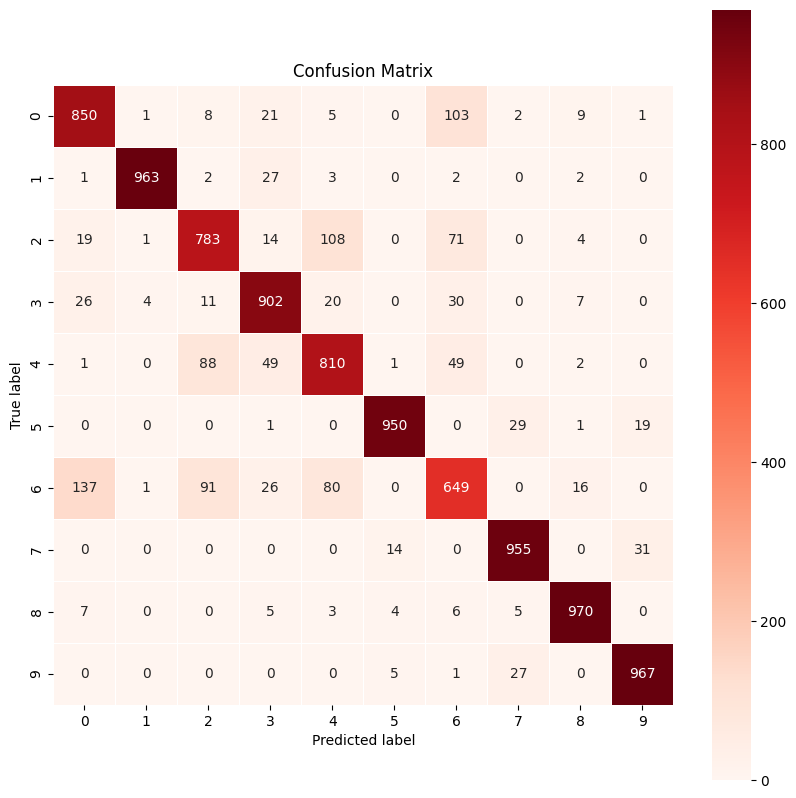

In [24]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_classes, predicted_classes)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap='Reds')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

As it was expected, the most mistaken objects are such as the (0) T-shirt/top with the (6) Shirt or, similarly, the (4)
Coat with, also, the (6) Shirt.

All in all, the classification is pretty satisfactory taking into account the simplicity of the NN and its low computational consumption.

## Conclusions <a class="anchor" id="apartado5"></a>

In the project involving the Fashion MNIST dataset, valuable insights were gained throughout the deep learning process. The approach to preprocessing, which encompassed flattening images, normalizing pixel values, and one-hot encoding labels, was essential in preparing the data for efficient learning. The division of the dataset into training and validation sets proved crucial for evaluating the model's performance and preventing overfitting. During the development of the neural network, a balance was achieved in the choice of structural hyperparameters, with the selection of a single hidden layer comprising 64 neurons and the ReLU activation function. This was instrumental in avoiding overfitting while maintaining computational efficiency. Furthermore, the application of grid search to fine-tune learning hyperparameters such as the optimizer, learning rate, epochs and metrics enabled a thorough exploration and optimization of the model, along with the batch size utilized, which was argued in the text.Regarding regularization, the exploration of various techniques led to the selection of dropout as the most effective method for mitigating overfitting without compromising the model's accuracy. This decision helped enhancing the model's robustness. 

Overall, the practices adopted in preprocessing, model building and regularization collectively contributed to the development of an effective deep learning model for the Fashion MNIST dataset, providing a template for future machine learning works and emphasizing the importance of each step in the deep learning process.